In [2]:
import numpy as np
from collections import defaultdict
import re
import math
import urllib.request
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/20_newsgroups.tar.gz"
urllib.request.urlretrieve(url, "20_newsgroups.tar.gz")

train_news20 = fetch_20newsgroups(subset='train', shuffle=True)

In [4]:
trainX = train_news20.data
trainY = train_news20.target

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shreyamalraju/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shreyamalraju/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
list_stop_words = set(stopwords.words('english'))
processed_trainX = []
for doc in trainX:
    words = word_tokenize(doc.lower())
    filtered_words = [word for word in words if word not in list_stop_words]
    processed_trainX.append(' '.join(filtered_words))

In [7]:
vocabulary = defaultdict(int)
for doc in processed_trainX:
    words = re.findall(r'\b\w+\b', doc)
    for word in words:
        vocabulary[word] += 1

In [8]:
min_count = 10
vocabulary = {k:v for k,v in vocabulary.items() if v >= min_count}


classes = defaultdict(int)
word_numbers = defaultdict(lambda: defaultdict(int))
for doc, y in zip(processed_trainX, trainY):
    classes[y] += 1
    words = re.findall(r'\b\w+\b', doc)
    for word in words:
        if word in vocabulary:
            word_numbers[y][word] += 1

In [9]:
prior = {}
for c in classes:
    prior[c] = classes[c] / len(trainY)

In [10]:
likelihood = {}
for c in word_numbers:
    likelihood[c] = {}
    total_words = sum(word_numbers[c].values())
    for word in vocabulary:
        likelihood[c][word] = (word_numbers[c][word] + 1) / (total_words + len(vocabulary))

In [11]:
def predict(doc):
    words = re.findall(r'\b\w+\b', doc.lower())
    filtered_words = [word for word in words if word not in list_stop_words]
    scores = {}
    for c in prior:
        scores[c] = math.log(prior[c])
        for word in filtered_words:
            if word in vocabulary:
                scores[c] += math.log(likelihood[c][word])
    return max(scores, key=scores.get)

In [12]:
y_pred = [predict(doc) for doc in processed_trainX]
train_accuracy = np.mean(np.array(y_pred) == trainY)
print("Accuracy on the training set: {:.2f}%".format(train_accuracy*100))

Accuracy on the training set: 91.45%


In [13]:

test_news20 = fetch_20newsgroups(subset='test', shuffle=True)


testX = test_news20.data
testY = test_news20.target


processed_testX = []
for doc in testX:
    words = word_tokenize(doc.lower())
    filtered_words = [word for word in words if word not in list_stop_words]
    processed_testX.append(' '.join(filtered_words))

y_pred = [predict(doc) for doc in processed_testX]
accuracy = np.mean(np.array(y_pred) == testY)
print("Accuracy on the testing set: {:.2f}%".format(accuracy*100))


Accuracy on the testing set: 79.26%


In [14]:
from sklearn.metrics import classification_report
target_names = test_news20.target_names
print(classification_report(testY, y_pred, target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.76      0.82      0.79       319
           comp.graphics       0.55      0.81      0.66       389
 comp.os.ms-windows.misc       0.15      0.01      0.01       394
comp.sys.ibm.pc.hardware       0.51      0.76      0.61       392
   comp.sys.mac.hardware       0.72      0.85      0.78       385
          comp.windows.x       0.84      0.75      0.79       395
            misc.forsale       0.79      0.84      0.81       390
               rec.autos       0.86      0.90      0.88       396
         rec.motorcycles       0.91      0.94      0.92       398
      rec.sport.baseball       0.93      0.92      0.93       397
        rec.sport.hockey       0.95      0.95      0.95       399
               sci.crypt       0.90      0.89      0.90       396
         sci.electronics       0.74      0.73      0.74       393
                 sci.med       0.92      0.81      0.86       396
         

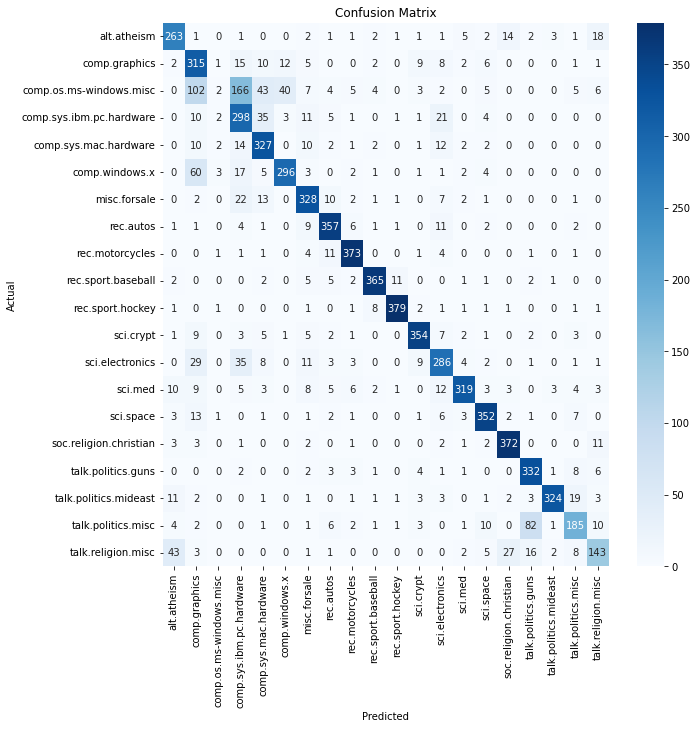

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testY, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=test_news20.target_names, yticklabels=test_news20.target_names, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

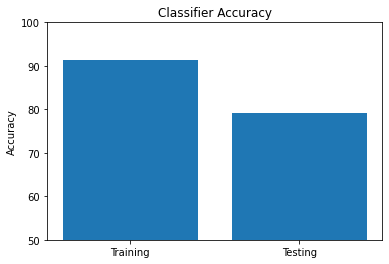

In [17]:
fig, ax = plt.subplots()
ax.bar(['Training', 'Testing'], [train_accuracy*100, accuracy*100])
ax.set_ylim([50,100])
ax.set_ylabel('Accuracy')
ax.set_title('Classifier Accuracy')
plt.show()